<a href="https://colab.research.google.com/github/bilallogiciel/FIX-Parser/blob/main/FIX_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataFolder = '/content/drive/MyDrive/FIX-Messages(1 month)/' 

In [34]:
import pandas as pd
import os
import glob
pd.options.mode.chained_assignment = None
dataFiles = []
txt_files = glob.glob(dataFolder + "*.txt")
#print(txt_files)
for filename in txt_files:  
    print("Reading File: ", filename)
    data = pd.read_fwf(filename, header=None)
    dataFiles.append(data)

#print(dataFiles[0])

Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-02 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-06 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-04 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-10 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-05 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-09 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-03 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-19 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-12-01 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-18 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-24 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-27 Messa

In [4]:
def GetTagValue(msg, tag):  
    splits = msg.split("\001")
    for s in splits:
        temp = s.split("=")
        #print(len(temp))
        if temp[0] == tag:
            if (len(temp)>1):    #For handling missing values in tags
                return temp[1]
    return -1       
        

In [5]:
def ToDataFrame(dataFiles, tags):
    dataChunks = []

    for data in dataFiles:
        rows = []

        for i in range(len(data)):
            row = []

            for tag in tags:
                msg = data.at[i,0]
                
                value = GetTagValue(msg, tag)
                #print("msg num: ", i, "tag: ", tag, "value: ", value)
                row.append(value)

            rows.append(row)

        dataChunks.append(pd.DataFrame(rows, columns = tags))
        
    dataFrame = pd.concat(dataChunks, ignore_index=True)
    return dataFrame

In [35]:
tags = ['52','55', '109', '35', '39', '100']
dataFrame = ToDataFrame(dataFiles, tags)
print(dataFrame)

                           52    55       109 35  39        100
0       20201102-13:33:09.955   SSO    ETFARB  D  -1  WEX-BESTX
1       20201102-13:33:10.049   SSO    ETFARB  8   0  WEX-BESTX
2       20201102-13:33:11.591   SSO    ETFARB  8   2  WEX-BESTX
3       20201102-13:33:19.812   QLD    ETFARB  D  -1  WEX-BESTX
4       20201102-13:33:19.988   QLD    ETFARB  8   0  WEX-BESTX
...                       ...   ...       ... ..  ..        ...
373458  20201117-21:14:34.857  SPXW  OPSPRTRD  D  -1  WEX-SWEEP
373459  20201117-21:14:34.867  SPXW  OPSPRTRD  8   0  WEX-SWEEP
373460  20201117-21:14:34.868  SPXW  OPSPRTRD  8   2  WEX-SWEEP
373461  20201117-21:15:01.299  SPXW  OPSPRTRD  D  -1  WEX-SWEEP
373462  20201117-21:15:01.325  SPXW  OPSPRTRD  8   8  WEX-SWEEP

[373463 rows x 6 columns]


In [36]:
#How many accounts have traded a particular security
#Most active traded accounts.
#Least active traded accounts.

#Finding the trades
#Tag 35=8 OR Tag 39=1 OR Tag 39=2
#Change 35=D later
Trades_df = dataFrame[(dataFrame['35'] == 'D')]
#print(Trades_df)

#Droping messages with missing account ID
#Trades_df = Trades_df.drop(Trades_df[Trades_df['109'] == -1].index)
#Trades_df = Trades_df.drop(Trades_df[Trades_df['109'] == ''].index)

#Renaming Missing account numbers to DEFAULT
Trades_df['109'] = Trades_df['109'].replace(['',-1],'DEFAULT')

#Taking out ONLY Account ID and Security out of dataframe
accounts_symbols = Trades_df.filter(['109','55'], axis=1)
#Finding the number of unique accounts
accounts = accounts_symbols['109'].unique()

#Grouping by Account ID and summing each security with it
accounts_symbols_count = []
for account in accounts:
    accounts_symbols_count.append(accounts_symbols[accounts_symbols['109'] == account].groupby(['55']).count())

#Finding Most traded Account, Min traded Account
most_trades = 0
most_trade_acc = 0
min_trade = accounts_symbols_count[0]['109'].sum()
min_trade_acc = 0
for i in range (0,len(accounts)):
    total = accounts_symbols_count[i]['109'].sum()
    if  (total > most_trades):
        most_trades = total
        most_trade_acc = accounts[i]

    if  (total < min_trade):
        min_trade = total
        min_trade_acc = accounts[i]

print("Account with most trades: ", most_trade_acc)
print("Number of trades: ", most_trades)
print("\nAccount with least trades: ", min_trade_acc)
print("Number of trades: ", min_trade)

#Displaying The results
for i in range(0,len(accounts)):
    accounts_symbols_count[i] = accounts_symbols_count[i].sort_values(by='109', ascending=False)
    total = accounts_symbols_count[i]['109'].sum()
    accounts_symbols_count[i] = accounts_symbols_count[i].transpose()
    accounts_symbols_count[i].reset_index(drop=True, inplace=True)
    print("\nAccount ID:", accounts[i], "Total Trades: ", total) 
    display(accounts_symbols_count[i])
    

Account with most trades:  ETFARB
Number of trades:  77562

Account with least trades:  EMS-JSC
Number of trades:  5

Account ID: ETFARB Total Trades:  77562


55,SSO,QLD,DBO,VXX,SOXX,FXI,YINN,CHAD,SVXY,TBF,UPRO,UVXY,TQQQ,GLD,UCO,SOXL,ASHR,USO,UGL,VIXY,SJNK,SHYG,TLT,TMV,TBT
0,40300,12766,7379,7304,2235,1722,1521,1206,761,717,375,203,202,200,184,147,90,71,53,52,42,12,12,6,2



Account ID: CEC Total Trades:  86


55,ZVZZT,BA,SLG,COP,CVS,UVV,WMB,JBLU,BSX,UDR,ALL,MET,PRU,MCK,MMC,MMP,MO,MUR,LPX,NI,OKE,WRI,RAD,XOM,SRE,L,T,TAP,TRV,USM,WFC,WHR,LLY,ADM,KR,KIM,AIG,AMGN,AMKR,AVB,AVT,BAC,BMY,C,CAH,CB,CI,CSCO,CVX,DHR,DIS,EMN,GD,GS,HAS,HIG,HR,JPM,AEP,JWN
0,14,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



Account ID: REVCON Total Trades:  2376


55,QS,SBE,FSR,RIDE,BLNK,TLRY,WKHS,JWN,XPEV,GME,ACB,CLVS,NKLA,LMND,HTZGQ,HYLN,KNDI,SPCE,NNOX,SRNE,INO,SDC,PLTR,TTCF,RKT,GRWG,VXRT,PIC,KODK
0,600,526,392,162,91,82,73,61,57,54,51,44,41,35,32,22,10,9,8,7,4,3,3,3,2,1,1,1,1



Account ID: OPSPRTRD Total Trades:  1975


55,TSLA,AAPL,SPXW,AMZN,BABA,FB,BA,MSFT,OSTK,NKLA,LI,PTON,AMD,RIOT,SPX,RIDE,PANW,KNDI,GRWG,QQQ,SPCE,BIIB,PYPL,NIO,AMAT,ROKU,QCOM,NFLX,KXIN,UBER,WORK,SNDL,DDOG,NLS,MRNA,CLDR,SNOW,DKNG,SPG,SPY,ARLO,SBUX,ZM,KODK,DIS,F,FSR,DBX,RKT,NDXP,MU,TWTR,TSM,BLNK,ACB,GE,SLV,IWM,SOLO,RNG
0,374,341,288,285,131,53,48,43,32,30,29,29,28,19,15,14,14,14,13,12,11,9,9,8,8,7,7,6,6,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1



Account ID: STOCKLOANPROP Total Trades:  29


55,HYLN
0,29



Account ID: EMS-JSC Total Trades:  5


55,SPY
0,5


In [ ]:
!pip install maya

In [ ]:
Trades_df = Trades_df.reset_index()
#display(Trades_df)

In [43]:
from datetime import datetime
import maya
#display(dataFrame)
times = Trades_df['52']
dt = []
hours = []
time = []
weekdays = []
day = []
dateTime = []

for i in range(0,len(times)):
    dt.append(maya.parse(times[i]).datetime())
    hours.append(dt[i].hour)
    weekdays.append(dt[i].strftime('%A'))
    time.append(dt[i].time())
    day.append(dt[i].day)
    dateTime.append(dt[i].strftime('%Y-%m-%dT%H:%M:%S%z'))          #This format is recognized by Kibana.

Trades_df['52'] = dateTime


In [44]:
from collections import Counter
#time_count = Counter(time)
hours_count = Counter(hours)
weekday_count = Counter(weekdays)
days_count = Counter(day)
#print(weekday_count)
#print(hours_count)
#print(days_count)

Counter({16: 15524, 15: 14921, 18: 13126, 17: 12204, 20: 10335, 19: 9806, 14: 5839, 13: 149, 21: 129})


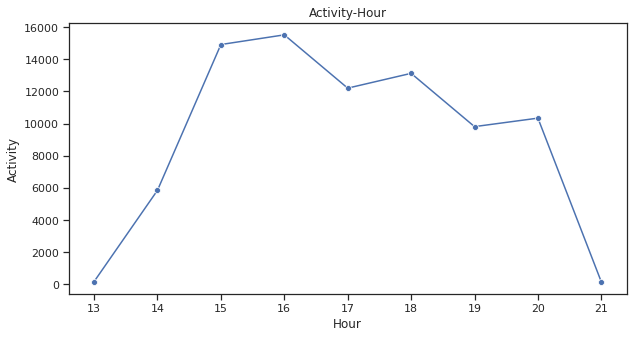

In [45]:
#Trade activity at a given time.
print(hours_count)
#print(dt[0])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("ticks")

plt.xlabel('Hour')
plt.ylabel('Activity')
plt.title('Activity-Hour')
sns.lineplot(data=hours_count, marker='o')
plt.show()

,WeekDay,Activity
0,Monday,18129
1,Tuesday,22235
2,Wednesday,13807
3,Thursday,13423
4,Friday,14439


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


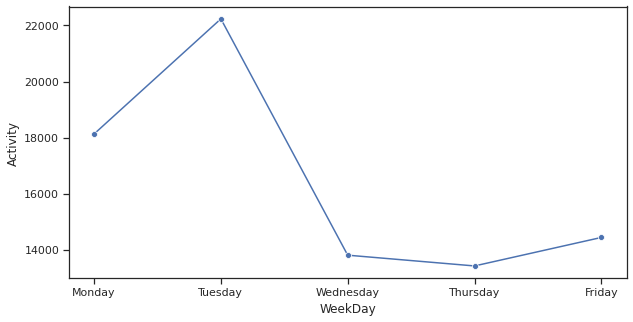

In [46]:
#Securities traded during weekdays
weekday_df = pd.DataFrame.from_dict(Counter(weekday_count), orient='index').reset_index()
weekday_df.columns =['WeekDay', 'Activity']
weekday_df['DayNumber'] = [0,4,2,1,3] 
weekday_df = weekday_df.sort_values(by='DayNumber').reset_index()
del weekday_df['DayNumber']
del weekday_df['index']
display(weekday_df) 
graph = sns.lineplot(weekday_df.WeekDay, weekday_df.Activity, marker='o')
plt.show()

,MonthDay,Activity
0,24,12448
1,20,10450
2,2,10278
3,4,7380
4,12,6855
5,5,5699
6,23,5663
7,3,5141
8,25,4193
9,10,2947


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


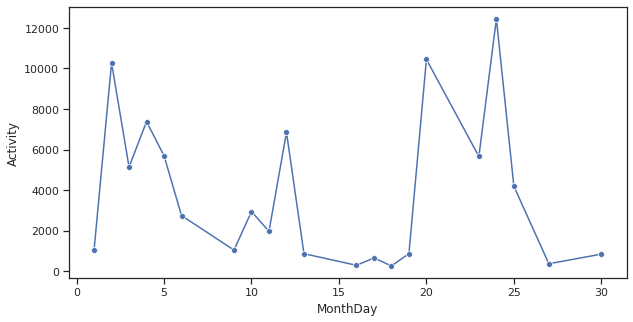

In [47]:
#How many securities are traded during the day.

days_df = pd.DataFrame.from_dict(Counter(days_count), orient='index').reset_index()
days_df.columns =['MonthDay', 'Activity']
days_df = days_df.sort_values(by='Activity', ascending = False).reset_index()
del days_df['index']
display(days_df)
graph = sns.lineplot(days_df.MonthDay, days_df.Activity, marker='o')
plt.show()

In [49]:
#Most traded securities.
Securities_count = Counter(Trades_df['55'])
securities_df = pd.DataFrame.from_dict(Securities_count, orient = 'index').reset_index()
securities_df.columns = ['Security','Activity']
securities_df = securities_df.sort_values(by='Activity', ascending=False).reset_index()
del securities_df['index']
display(securities_df)

,Security,Activity
0,SSO,40300
1,QLD,12766
2,DBO,7379
3,VXX,7304
4,SOXX,2235
...,...,...
156,LLY,1
157,VXRT,1
158,IWM,1
159,AEP,1


In [50]:
#Time at which most of the activity happened.
print("Day of month with most activity is 24: ", days_count[24])
print("Hour of day with most activity is 16: ", hours_count[16])
print("Day of Week with most activity is 1: ", weekday_df['Activity'][3])

Day of month with most activity is 24:  12448
Hour of day with most activity is 16:  15524
Day of Week with most activity is 1:  13423


In [57]:
#How many executions from a specific destination.
dest_count = Counter(Trades_df['100'])
dest_df = pd.DataFrame.from_dict(dest_count, orient='index').reset_index()
#dest_df = dest_df.drop([5,9], axis=0).reset_index()
#del dest_df['level_0']
dest_df.columns =['Destination (tag=100)', 'Activity']
dest_df = dest_df.sort_values(by='Activity', ascending=False).reset_index()
del dest_df['index']
display(dest_df)

,Destination (tag=100),Activity
0,WEX-BESTX,78604
1,WEX-BESTX-OPT,1659
2,WEX-SWEEP,1250
3,WEX-SWEEPX,404
4,WEX-PRIMARYX,87
5,ARCA,19
6,ARCA-OTC,7
7,WEX-VWAP,2
8,PUMA-DESK,1


In [58]:
#Latency/time taken by any destination after accepting the order and completely filling the order.
#Finding Difference between Transect Time (tag 60) and Sending Time (tag 52)
tags = ['60']
transectTime_df = ToDataFrame(dataFiles, tags)

In [59]:
transectTime = transectTime_df['60']
sendingTime = dataFrame['52']

tTime = []
sTime = []
for i in transectTime:
    tTime.append(maya.parse(i).datetime())
    sTime.append(maya.parse(i).datetime())

#print(tTime[0])

In [75]:
len(tTime)

373463

In [87]:
from datetime import time
from datetime import timedelta

timeDifference = []
for i in range(0,len(tTime)):
    timeDifference.append(tTime[i]-sTime[i])

#print(timeDifference[0].total_seconds())

any_delay = False
for i in timeDifference:
    if i.total_seconds() != 0:
        any_delay = True
        print("Network Delay Found: ", timeDifference)

if not any_delay:
    print("No Network Delay Found")
        

No Network Delay Found


In [97]:
#del Trades_df['index']
#del Trades_df['39']
#del Trades_df['OrdStatus']

dataToWrite = dataFrame
tradeDataToWrite = Trades_df
dataToWrite.columns = ['SendingTime', 'Security', 'Account', 'MessageType', 'OrdStatus', 'ExDestination']
tradeDataToWrite.columns = ['SendingTime', 'Security', 'Account', 'MessageType', 'ExDestination']
#print(dataToWrite)

dataToWrite.to_csv(os.path.join(dataFolder, 'CleanData.csv'), index=False)
tradeDataToWrite.to_csv(os.path.join(dataFolder, 'TradeData.csv'), index=False)